# Neighborhood Analysis

This notebook's goal is to figure out what neighborhood in the Pittsburgh area has the best availability of POGOH bike share. I picked this as a metric because making bikes more accessible encourages a form of transport that's cheap and healthy, which has a positive effect on the lives of citizens. Besides that, it could point towards better bike infrastructure and willingness to adopt newer programs and initiatives (like POGOH).

Two alternatives I considered:
1. **Availability of bike lanes** &mdash; The data for this on WPRDC was a bit outdated (2016), and data on how often cars would park in bike lanes and make them unusable was a separate WPRDC dataset (Also dated back to 2019)
2. **POGOH trips** &mdash; Would probably have been biased toward areas with higher populations, or areas like Oakland where lots of people can use their Pitt IDs to take bikes out for trips without paying anything

## Metric

The dataset I used: https://data.wprdc.org/dataset/pogoh-trip-data ([+ this](https://data.wprdc.org/dataset/neighborhoods2) for boundary geometry)

I looked at two things to calculate availability:
1. **Number of POGOH stations** &mdash; how many stations are inside the neighborhood.
2. **Average number of bike docks** &mdash; average count of bike docks at each contained station.

I multiplied these two features to come up with a final score indicating both how prevalent POGOH stations are in each area, and how many bikes could be expected at an average station.

In [7]:
# Install and import dependencies
%pip install openpyxl geopandas branca folium mapclassify
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Paths to each dataset
AREAS_FILE = 'neighborhoods/Neighborhoods_.shp'
STATIONS_FILE_XLSX = 'pogoh-station-locations-october-2025.xlsx'
STATIONS_FILE_CSV = 'pogoh-oct2025.csv'

In [9]:
# Convert *.xlsx dataset to *.csv
df = pd.read_excel(STATIONS_FILE_XLSX)
df.to_csv(STATIONS_FILE_CSV, index=False)

In [10]:
# Load neighborhoods from shapefile. (https://data.wprdc.org/dataset/neighborhoods2)
areas = gpd.read_file(AREAS_FILE)
areas.explore("acres", legend=False)

In [11]:
# Open POGOH stations dataset w/ pandas
stationsf = open(STATIONS_FILE_CSV, 'rb')
stations = pd.read_csv(stationsf)

# Convert to geopandas dataframe with longitude / latitude coordinates
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude), crs="EPSG:4326")

# Convert longitude/latitude to CRS used by neighborhoods dataset
stations = stations.to_crs(2272)

# Show stations data
stations

,Id,Name,Total Docks,Latitude,Longitude,geometry
0,1,Pierce St & Summerlea St,19,40.456507,-79.932331,POINT (1361269.043 416661.333)
1,2,Eliza Furnace Trail & Swineburne St,15,40.425800,-79.953400,POINT (1355128.64 405623.969)
2,3,Centre Ave & Addison St,15,40.444600,-79.978300,POINT (1348371.36 412644.529)
3,4,Burns White Center at 3 Crossings,15,40.456400,-79.980000,POINT (1348006.894 416953.838)
4,5,Allegheny Station,19,40.448301,-80.018007,POINT (1337358.062 414273.666)
5,6,10th St & Penn Ave,15,40.444653,-79.996074,POINT (1343426.491 412788.992)
6,7,Liberty Ave & Gross St,15,40.459588,-79.945204,POINT (1357715.806 417872.179)
7,8,Glasshouse,15,40.432900,-80.003000,POINT (1341390.186 408558.023)
8,9,South Side Trail & S 4th St,15,40.431336,-79.995106,POINT (1343572.478 407932.486)
9,10,Zulema St & Coltart Ave,19,40.436055,-79.956827,POINT (1354268.194 409382.505)


In [12]:
# Join each station with the neighborhood it's contained by on the map
stations_with_area = stations.sjoin(areas, how='inner', predicate='intersects')
stations_with_area

,Id,Name,Total Docks,Latitude,Longitude,geometry,index_right,OBJECTID,fid_blockg,statefp10,...,plannerass,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len
0,1,Pierce St & Summerlea St,19,40.456507,-79.932331,POINT (1361269.043 416661.333),75,76,167,42,...,Christian Umbach,SDE,2020-08-14,SDE,2020-08-14,None,25673624.0,08cfd3ac-e8f8-4d3d-86fc-534367f67428,2.565261e+07,25073.867049
1,2,Eliza Furnace Trail & Swineburne St,15,40.425800,-79.953400,POINT (1355128.64 405623.969),60,61,34,42,...,Austin Herzog,SDE,2020-08-14,SDE,2020-08-14,None,44132028.0,c30655c8-cf46-4785-88c0-33dc03480284,4.475160e+07,42554.188468
2,3,Centre Ave & Addison St,15,40.444600,-79.978300,POINT (1348371.36 412644.529),6,7,348,42,...,Ose Akinlotan,SDE,2020-08-14,SDE,2020-08-14,None,8503223.0,ab7c6002-5eb8-40fb-871f-51c8acf71402,8.506822e+06,14507.764273
3,4,Burns White Center at 3 Crossings,15,40.456400,-79.980000,POINT (1348006.894 416953.838),81,82,5,42,...,Alex Peppers,SDE,2020-08-14,SDE,2020-08-14,None,16947852.0,5e353b5c-a9d4-4b0a-a1aa-31d3bf847639,1.695675e+07,23770.202969
4,5,Allegheny Station,19,40.448301,-80.018007,POINT (1337358.062 414273.666),74,75,201,42,...,Stephanie Joy Everett,SDE,2020-08-14,SDE,2020-08-14,None,10688264.0,b685a912-54de-4e6c-8b17-9128949d51bc,1.066384e+07,19827.929328
5,6,10th St & Penn Ave,15,40.444653,-79.996074,POINT (1343426.491 412788.992),43,44,6,42,...,Alex Peppers,SDE,2020-08-14,SDE,2020-08-14,None,17846686.0,31b560f2-ca21-41de-ac55-0fe3fc8048e5,1.502223e+07,17837.723820
6,7,Liberty Ave & Gross St,15,40.459588,-79.945204,POINT (1357715.806 417872.179),52,53,73,42,...,"Vacant, contact Ose Akinlotan (Planning Manager)",SDE,2020-08-14,SDE,2020-08-14,None,19572930.0,dfd12465-ae1b-403c-a198-8d590aa69878,1.956871e+07,21224.748894
7,8,Glasshouse,15,40.432900,-80.003000,POINT (1341390.186 408558.023),66,67,151,42,...,Nancy Hirsch,SDE,2020-08-14,SDE,2020-08-14,None,5905659.5,d5f7d36e-e24e-4a25-8235-4c8e98ad4440,6.432793e+06,21736.873396
8,9,South Side Trail & S 4th St,15,40.431336,-79.995106,POINT (1343572.478 407932.486),88,89,16,42,...,Thomas Scharff,SDE,2020-08-14,SDE,2020-08-14,None,26083320.0,39308990-70d5-4da6-b2a0-a5510f18e9b9,2.576841e+07,34700.371969
9,10,Zulema St & Coltart Ave,19,40.436055,-79.956827,POINT (1354268.194 409382.505),46,47,0,42,...,Christian Umbach,SDE,2020-08-14,SDE,2020-08-14,None,7843108.0,65e4f81f-d61f-4219-ad62-b4167006f5d6,7.807258e+06,11495.260313


In [13]:
# Draw a map of the neighborhoods, with the stations overlayed
m = areas.explore(
    column="acres",
    tooltip="hood",
    tooltip_kwds=dict(labels=False),
    legend=False,
    name="areas",
)
stations_with_area.explore(
    m=m,
    color="red",
    marker_kwds=dict(radius=5, fill=True),
    name="stations",
)
folium.TileLayer("CartoDB positron", show=False).add_to(m)
folium.LayerControl().add_to(m)
m

# Conclusion

Central Oakland is the best neighborhood for bike share availability in Pittsburgh

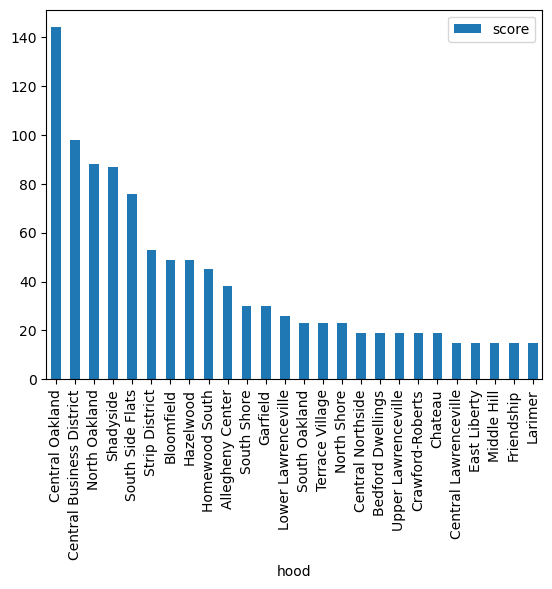

In [15]:
# Group stations by neighborhood
groups = stations_with_area.groupby("hood")

# Count how many stations each has,
# and the average number of POGOH stations
groups = groups["Total Docks"].agg(["count", "mean"])
# Multiply into final score
groups["score"] = groups["count"] * groups["mean"]

# Plot
groups = groups.sort_values(by="score", ascending=False)
groups.plot.bar(y="score")
plt.show()